In [52]:
%matplotlib ipympl
import numpy as np
from numpy.fft import  ifft2, ifftshift
#from scipy.special import kv as beselk
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from ows import ows
import time

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

## PSD
Power spectrum density

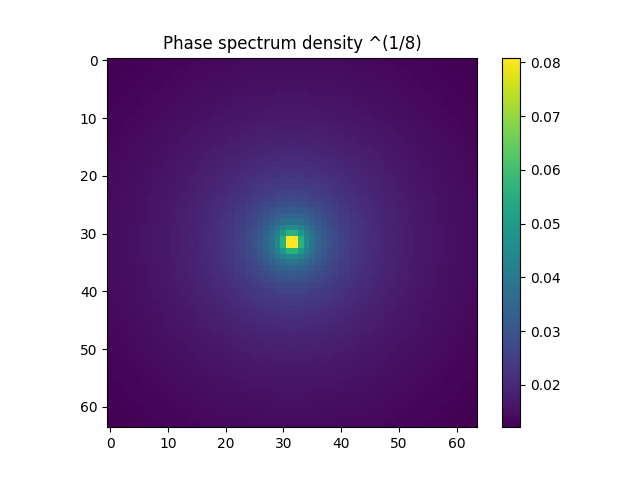

In [53]:
dimmat = 64   # Matrix size
r0 = .1
L0 = -1

FoV = 60 # arcsec
Npx = 540 # image plane pixels qty

Daf = 0.01#asec2rad*FoV/Npx # [rad/px]  (Numerical aperture)
wl = 500e-9 # [m]

dfp = Daf/wl # [/m] Pupil plane spatial frequency pixel size (Numerical aperture/WL)
dxp = 1/(dfp*dimmat) # Pupil plane pixel size
#DFP = 1/dxp/dimmat

PSD = ows.psd(dimmat, dxp, r0, wl)

plt.close(1)
plt.figure(1)
plt.imshow(PSD**(1/8))
plt.title("Phase spectrum density ^(1/8)")
plt.colorbar()

dim:  1
dim:  1
dim:  1
tst type:  complex128
tst1 type:  complex128


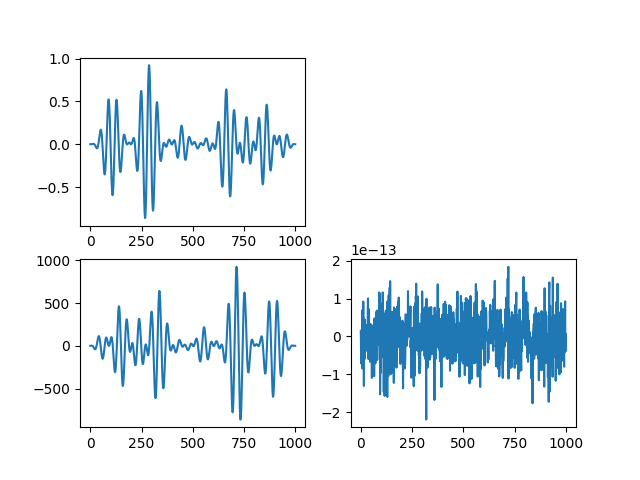

In [ ]:
from numpy.fft import  fft, fft2, ifft, fftshift, ifftshift

t = np.linspace(0,1,1000)
object = np.sin(2*np.pi*t)*np.sin(5*np.pi*t)*np.sin(5.5*np.pi*t)*np.sin(50.5*np.pi*t)
#object = np.random.rand(64,64)
print('dim: ',object.ndim)

def mathft(object,dx=1.0, center = np.array([0,0]),INVERSE=False):
    
    object_dim = object.ndim
    object_shape = object.shape
    fNyquist = 0.5/dx
    print('dim: ', object_dim)
    df=1.0/(object_shape[0]-(object_shape[0] % 2))/dx 


    if (object_dim == 1 and center[0]==0) or (object_dim == 2 and center[0]==0 and center[1]==0):
        if INVERSE == False:
            if object_dim == 1:
                #object = np.roll(fft(object.reshape(-1)[0:object_shape[0]-1-(object_shape[0]%2)]),(object_shape[0]-(object_shape[0] % 2)//2))/df
                object = np.roll(fft(object.reshape(-1)),(object_shape[0]-(object_shape[0] % 2)/2))/df
                #object = fftshift(fft(object.reshape(-1)))/df
                
            elif object_dim == 2:
                object = fftshift(fft(object.reshape(-1)))/df**2
                #object = fftshift(fft(object.reshape(-1)[0:object_shape[0]-1-(object_shape[0]%2),0:object_shape[0]-1-(object_shape[0]%2)]),(object_shape[0]-(object_shape[0]%2)/2),(object_shape[0]-(object_shape[0]%2)/2),axes=(0, 1))/df**2
        else:
            if object_dim == 1:
                #object = fft(df*np.roll(object.reshape(-1)[0:object_shape[0]-1-(object_shape[0]%2)],(object_shape[0]-(object_shape[0] % 2)//2)))
                object = fft(df*np.roll(object.reshape(-1),(object_shape[0]-(object_shape[0] % 2)/2)))
            elif object_dim == 2:
                object = ifft((df**2)*fftshift(object.reshape(-1)))

    return object

tst = mathft(object,dxp)
tst1 = mathft(tst,dxp,INVERSE=True)
print('tst type: ',tst.dtype)
print('tst1 type: ',tst1.dtype)
#tst = mathft(object,dxp,inverse=True)
plt.close(2)
plt.figure(2)
plt.subplot(2,2,1)
plt.plot((object))
plt.subplot(2,2,3)
plt.plot((tst1.real))
plt.subplot(2,2,4)
plt.plot((tst1.imag))
#plt.colorbar()
plt.show()


## Phase screen

Processingtime : 4.000186920166016 ms


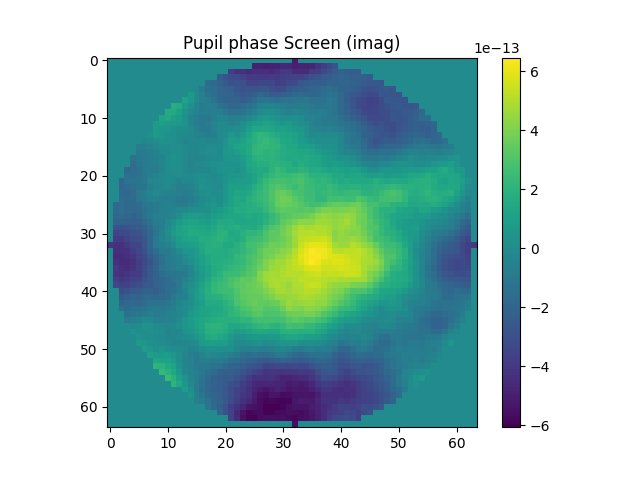

In [ ]:
SEED = 0



def phase_screen(dimmat, PSD, dxp, SEED = None, PUPIL = True):
    
    PP = np.zeros((dimmat+1, dimmat+1)) # Phase power [dimmat+1, dimmat+1] in order to have a pixcele in the middle [rad^2/m^-2]
   
    PP[0:dimmat,0:dimmat] = PSD*(dimmat*dxp)**2
    #TODO: understand what this is here
    PP[0 : dimmat, dimmat] = PP[0 : dimmat, 0] # last row = 1st row
    PP[dimmat,0 : dimmat] = PP[0, 0 : dimmat] # last column = 1st column
    PP[dimmat, dimmat] = PP[0, 0] # bottom right corner = top left corner

    if SEED is not None:
      np.random.seed(SEED)
    PSA = np.sqrt(PP)* np.random.rand(dimmat+1,dimmat+1) # random draw to create a random phase spectrum [rad/m^(-1)] AMPLITUDE
    PSA = np.sqrt(2)*(PSA+np.rot90(np.rot90(PSA,2)))/2 # forced even amplitude of wf spectrum
    PSop = np.random.rand(dimmat+1,dimmat+1)*2*np.pi # random draw for the phase of the spectrum of the optical phase
    # in order to make sure that the phase is real,
    # (1) the real part of the phase spectrum is forced to be even (as in "f(x) is even")
    # (2) the imaginary part of phase spectrum is forced to be odd (as in "f(x) is odd")
    phaseft =  (PSA * np.cos(0.5 * (PSop - np.rot90(np.rot90(PSop)))))[0:dimmat,0:dimmat] + 1j*(PSA * np.sin(0.5 * (PSop - np.rot90(np.rot90(PSop)))))[0:dimmat,0:dimmat]

    MASK = np.ones((dimmat,dimmat))
    if PUPIL is True:
      pxR = np.linspace(-1 ,1,dimmat)*dimmat//2
      xx, yy = np.meshgrid(pxR,pxR)
      R= np.sqrt(xx**2 + yy**2)  # pupil plane spatial frequency radius
      # Créer le masque pour exclure les pixels à l'intérieur du cercle
      MASK[R > dimmat/2] = 0
  
    phase_screen = np.fft.ifft2(np.fft.ifftshift(phaseft))*MASK
    phase_screen[MASK == 1] -= np.mean(phase_screen[MASK == 1])

    Sp = np.sum(phase_screen)*dxp**2
    apsf = np.fft.ifft2((MASK*np.exp(phase_screen)))/Sp
    psf = np.abs(apsf)**2
    phase_screen -= np.mean(-1j*phase_screen) # remove piston?
    return phase_screen

# ;INSTANTANEOUS PSF [OPTION]
#   if size(pupil,/type) ne 0 then begin
#     tmp2 = pupil*tmp2
#     tmp2[where(pupil ne 0)] = tmp2[where(pupil ne 0)]-mean(tmp2[where(pupil ne 0)])
#     Sp = total(pupil)*DXP^2
#     apsf = MATHFT(pupil*exp(-dcomplex(0,1)*tmp2),dx = DXP,ic = DIMMAT/2,jc = DIMMAT/2)/Sp
#     psf = abs(apsf)^2
#     if n_params() eq 5 then dxf = DFP*1e-6*LAMBDA/!dpi*180*3600
#   endif

start = time.time()

phase_screen = phase_screen(dimmat, PSD, dxp, SEED, PUPIL = True)

end = time.time()


print("Processingtime :",
      (end-start) * 10**3, "ms")

plt.close(3)
plt.figure(3)
plt.imshow(np.imag(phase_screen))
plt.title("Pupil phase Screen (imag)")
plt.colorbar()
plt.show()
